### tool 설치

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.5 MB/s eta 0:00:00


### Behind the pipeline

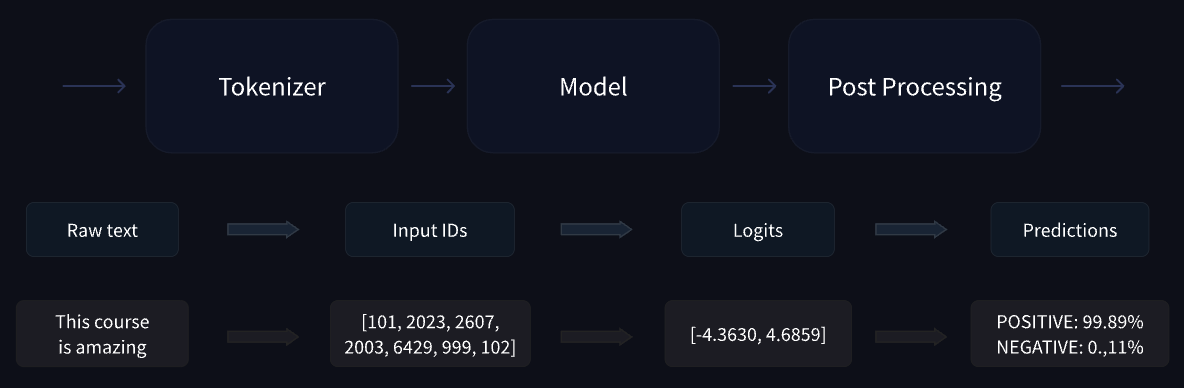

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

#### 📌 토크나이저를 사용한 전처리

* 입력을 토큰(단어, 하위단어, 기호)로 분할함.
* 각 토큰을 정수로 매핑.
* 모델에 유용할 수 있는 입력을 추가.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" # 사전 훈련된 것 사용
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
raw_inputs = [
    "I look forward to taking a master's degree program",
    "The movie was so terrible",
    "Let me introduce myself",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[ 101, 1045, 2298, 2830, 2000, 2635, 1037, 3040, 1005, 1055, 3014, 2565,
          102],
        [ 101, 1996, 3185, 2001, 2061, 6659,  102,    0,    0,    0,    0,    0,
            0],
        [ 101, 2292, 2033, 8970, 2870,  102,    0,    0,    0,    0,    0,    0,
            0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}


#### 📌 사전 훈련된 모델 다운로드

AutoModel 이란?
* checkpoint를 기반으로 올바른 architecture를 반환하는 개체

In [13]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

Transformer 모듈의 벡터 출력 (고차원 벡터)

* batch size : 한 번에 처리되는 시퀀스 수(예제에서는 2)입니다.
* sequence length : 시퀀스의 숫자 표현 길이입니다(이 예에서는 16).
* hidden size : 각 모델 입력의 벡터 차원입니다.


In [14]:
# **inputs는 inputs 딕셔너리의 키와 값들을 키워드 인수로 "언패킹"하는 역할을 함.

outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([3, 13, 768])


모델 헤드
* Transformer의 예측을 task-specific output으로 변환해줌.

In [15]:
# 이 예에서는 문장을 긍정 또는 부정으로 분류할 수 있도록 시퀀스 분류 헤드가 있는 모델이 필요
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [17]:
print(outputs.logits.shape)

torch.Size([3, 2])


In [18]:
# 확률이 아니라 모델의 마지막 계층에서 출력되는 정규화되지 않은 원시 점수인 로지트임.
print(outputs.logits)

tensor([[-2.7003,  2.8081],
        [ 4.6752, -3.8102],
        [-3.7207,  3.8648]], grad_fn=<AddmmBackward0>)


#### 📌 출력 후처리

 확률로 변환하려면 SoftMax 레이어를 거쳐야함.

In [22]:
import numpy as np
np.set_printoptions(suppress=True)

In [23]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0359e-03, 9.9596e-01],
        [9.9979e-01, 2.0641e-04],
        [5.0754e-04, 9.9949e-01]], grad_fn=<SoftmaxBackward0>)


In [25]:
predictions.detach().numpy()

array([[0.00403588, 0.99596405],
       [0.9997936 , 0.00020641],
       [0.00050754, 0.9994924 ]], dtype=float32)

In [20]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

### Models

#### 📌 Creating a Transformer

BERT 모델을 초기화하기 위해 가장 먼저 해야 할 일은 구성 객체를 로드하는 것

In [26]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

In [27]:
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



다른 로드 방법! -> 사전 학습된 Transformer 모델을 로드하는 것

In [28]:
model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [29]:
model.save_pretrained("directory_on_my_computer")

* config.json 파일을 살펴보면 모델 아키텍처를 구축하는 데 필요한 속성이 있음.
* 체크포인트가 어디서 생성되었는지
* 체크포인트를 마지막으로 저장했을 때 사용한 Transformers 버전과 같은 일부 메타데이터도 포함.

In [31]:
!ls directory_on_my_computer

config.json  model.safetensors


#### 📌 Using a Transformer model for inference

In [32]:
sequences = ["Hello!", "Cool.", "Nice!"]
# 토크나이저는 이를 일반적으로 입력 ID 라고 하는 어휘 색인으로 변환함.

In [33]:
# 각 시퀀스는 숫자 목록임. 예시 출력 결과!
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

In [34]:
import torch

model_inputs = torch.tensor(encoded_sequences)

In [36]:
model_inputs

tensor([[ 101, 7592,  999,  102],
        [ 101, 4658, 1012,  102],
        [ 101, 3835,  999,  102]])

In [35]:
output = model(model_inputs)

### Tokenizers

토큰화 알고리즘 1) 단어 기반
* 텍스트를 단어로 분할, 각 단어에 대한 숫자 표현을 찾음.
* 입력 ID map이 너무 큼. unknown token 많아질 우려.

In [38]:
tokenized_text = "Jisu wants to go horseriding!".split()
print(tokenized_text)

['Jisu', 'wants', 'to', 'go', 'horseriding!']


토큰화 알고리즘 2) 문자 기반
* 텍스트를 chracter로 분할.
* 입력 ID Map(a,b,c,d,e,...)은 작지만, 토큰이 너무 많아짐.
* 언어에 따라 다름. 중국어는 각 문자가 의미/정보를 가짐.

토큰화 알고리즘 3) 하위 단어 토큰화
* 위 두가지 접근 방식을 결합함.
* ex) annolyingly -> annolying, ly로 분해.
* "희귀한 단어는 의미있는 하위 단어로 분해해야한다."
* GPT-2에서 사용되는 바이트 수준 BPE
* BERT에서 사용되는 WordPiece
* 여러 다국어 모델에 사용되는 SentencePiece 또는 Unigram

#### 📌 load 및 save

In [41]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [42]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [43]:
tokenizer("Jisu wants to go horseriding!")

{'input_ids': [101, 13997, 6385, 3349, 1106, 1301, 3241, 10132, 1158, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [44]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json',
 'directory_on_my_computer/tokenizer.json')

#### 📌 Encoding

In [45]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Jisu wants to go horseriding!"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Ji', '##su', 'wants', 'to', 'go', 'horse', '##rid', '##ing', '!']


위 출력 결과를 보면, 하위 단어 토큰화인 것을 파악할 수 있다.

In [46]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[13997, 6385, 3349, 1106, 1301, 3241, 10132, 1158, 106]


#### 📌 Decoding

In [48]:
decoded_string = tokenizer.decode([13997, 6385, 3349, 1106, 1301, 3241, 10132, 1158, 106])
print(decoded_string)

Jisu wants to go horseriding!


### Handling multiple sequences

#### 📌 Models expect a batch of inputs

모델은 일괄 입력을 기대함.

In [49]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

IndexError: too many indices for tensor of dimension 1

위 출력이 실패한 이유는 우리가 모델에 단일 시퀀스를 보냈지만, Transformers 모델은 기본적으로 여러 문장을 기대하기 때문이다.

In [50]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


 입력 ID 목록을 텐서로 변환한 것이 아니라 그 위에 차원을 추가해야 에러가 생기지 않는다.

In [51]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


In [52]:
input_ids = torch.tensor([ids, ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012],
        [ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789],
        [-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


In [67]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I hate this so much!"

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[1045, 5223, 2023, 2061, 2172,  999]])
Logits: tensor([[ 3.1931, -2.6685]], grad_fn=<AddmmBackward0>)


#### 📌 Padding the inputs

다음 목록 목록은 텐서로 변환할 수 없다.

In [53]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

* 이 문제를 해결하기 위해 패딩을 사용하여 텐서를 직사각형 모양으로 만든다.

*  패딩은 더 적은 값을 가진 문장에 패딩 토큰 이라는 특수 단어를 추가하여 모든 문장의 길이를 동일하게 만든다.

In [54]:
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


* 위 결과를 보면, 두 예측 결과가 같아야하지만, 다른 결과값을 뱉는다.
* 이는 패딩을 포함한 시퀀스의 모든 토큰이 참여하기 떄문이다.
* mask를 사용하여 패딩 토큰을 무시되도록 해야한다!

#### 📌 Attention masks

 attention_mask에서 1은 해당 토큰에 주의해야 함을 나타내고 0은 해당 토큰에 주의하지 않아야 함을 나타냄.

In [56]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


In [57]:
sequence = "I've been waiting for a HuggingFace course my whole life."
tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

In [59]:
sequence2 = "I hate this so much!"
tokens2 = tokenizer.tokenize(sequence2)
ids2 = tokenizer.convert_tokens_to_ids(tokens2)

In [66]:
batched_ids = [
    ids,
    ids2 + [tokenizer.pad_token_id]*(len(ids)-len(ids2)),
]

attention_mask = [
    [1] * len(ids),
    [1] * len(ids2) + [0] * (len(ids)-len(ids2)),
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[-2.7276,  2.8789],
        [ 3.1931, -2.6685]], grad_fn=<AddmmBackward0>)


* Logits: tensor([[-2.7276,  2.8789]],
* Logits: tensor([[ 3.1931, -2.6685]]
* padding을 추가해도 앞선 출력값과 똑같이 나오는 것을 확인할 수 있다.
* Attention Maks의 중요성 입증!

#### 📌 Longer sequences

* Transformer 모델의 경우 모델을 전달할 수 있는 시퀀스의 길이에 제한적.
* 대부분의 모델은 최대 512개 또는 1024개 토큰의 시퀀스를 처리하며 더 긴 시퀀스를 처리하라는 요청을 받으면 충돌이 발생.
* 해결책 1) 지원되는 시퀀스 길이가 더 긴 모델을 사용.
* 해결책 2) 시퀀스를 자름.

In [ ]:
max_sequence_length = 512
sequence = sequence[:max_sequence_length]

### Putting it all together

In [68]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

단일 시퀀스를 토큰화

In [69]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)

한 번에 여러 시퀀스를 처리

In [70]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)

여러 가지 목적에 따라 패딩할 수 있음.

In [71]:
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)

시퀀스를 자를 수도 있음.

In [72]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)

객체 tokenizer는 특정 프레임워크 텐서로의 변환을 처리할 수 있으며, 그런 다음 이를 모델로 직접 보낼 수 있음.

In [73]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")

#### 📌 특수 토큰

토큰 ID는 처음에 하나, 끝에 하나가 추가

In [74]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


토크나이저는 시작 부분에 특수 단어[CLS]를 추가 하고 끝에 [SEP]특수 단어를 추가

이는 모델이 이러한 항목으로 사전 학습되었기 때문에 동일한 추론 결과를 얻으려면 해당 항목도 추가해야 하기 때문

In [75]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


#### 📌 Wrapping up: From tokenizer to model

In [76]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)